In [1]:
import sys
sys.path.append('../../code/hnn_beta')
import os
import numpy as np
import dill
import torch
from functools import partial
from scipy.stats import wasserstein_distance
from utils import (linear_scale_forward, log_scale_forward, UniformPrior,
                   simulator_hnn, hnn_beta_param_function, load_prerun_simulations,
                   get_dataset_psd, get_dataset_peaks, load_posterior)
from sklearn.decomposition import PCA
from hnn_core import jones_2009_model

import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
sns.set_style("white")

device = 'cpu'

net = jones_2009_model()
net.clear_connectivity()

data_path = '../../data/hnn_beta'

with open(f'{data_path}/posteriors/hnn_beta_posterior_dicts.pkl', 'rb') as output_file:
    posterior_state_dicts = dill.load(output_file)
with open(f'{data_path}/sbi_sims/prior_dict.pkl', 'rb') as output_file:
    prior_dict = dill.load(output_file)
with open(f'{data_path}/sbi_sims/sim_metadata.pkl', 'rb') as output_file:
    sim_metadata = dill.load(output_file)
with open(f'{data_path}/posteriors/hnn_beta_posterior_metadata.pkl', 'rb') as output_file:
    posterior_metadata = dill.load(output_file)
    
dt = sim_metadata['dt'] # Sampling interval used for simulation
tstop = sim_metadata['tstop'] # Sampling interval used for simulation

t_vec = np.linspace(0, tstop, np.round(tstop/dt).astype(int))


prior = UniformPrior(parameters=list(prior_dict.keys()))
n_params = len(prior_dict)
limits = list(prior_dict.values())

# x_orig stores full waveform to be used for embedding
x_orig, theta_orig = np.load(f'{data_path}/sbi_sims/x_sbi.npy'), np.load(f'{data_path}/sbi_sims/theta_sbi.npy')
x_cond, theta_cond = np.load(f'{data_path}/sbi_sims/x_grid.npy'), np.load(f'{data_path}/sbi_sims/theta_grid.npy')

x_orig = x_orig[:,0,:]
x_cond = x_cond[:,0,:]

load_info = {name: {'x_train': posterior_dict['input_dict']['feature_func'](x_orig), 
                    'x_cond': posterior_dict['input_dict']['feature_func'](x_cond)}
             for name, posterior_dict in posterior_state_dicts.items()}




pca30


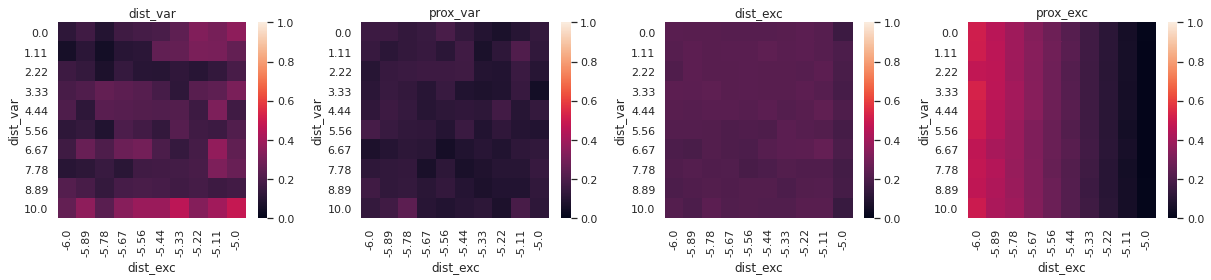

In [2]:
%matplotlib inline
plot_labels = list(prior_dict.keys())
param_labels = list(prior_dict.keys())
all_bounds = [param_dict['bounds'] for param_dict in prior_dict.values()]

for input_type, posterior_dict in posterior_state_dicts.items():
    if input_type in ['psd_peak']:
        continue
    print(input_type)
    
    theta_val = np.load(f'{data_path}/validation_sims/theta_{input_type}_validation.npy')

    dist_list = list()
    for cond_idx in range(theta_cond.shape[0]):
        start_idx, stop_idx = cond_idx*10, (cond_idx+1)*10
        dist = [wasserstein_distance(theta_val[start_idx:stop_idx, param_idx], [theta_cond[cond_idx,param_idx]]) for
                param_idx in range(theta_cond.shape[1])]
        dist_list.append(dist)
    dist_array = np.array(dist_list)

    plt.figure(figsize=(17,4))
    for plot_idx in range(4):
        plt.subplot(1,4,plot_idx+1)
        xticks = np.round(np.linspace(all_bounds[3][0], all_bounds[3][1], 10), decimals=2)
        yticks = np.round(np.linspace(all_bounds[0][0], all_bounds[0][1], 10), decimals=2)
        sns.heatmap(dist_array[:,plot_idx].reshape(10,10,10,10)[:,5,5,:], vmin=0, vmax=1.0,
                    xticklabels=xticks, yticklabels=yticks)
        plt.title(plot_labels[plot_idx])
        plt.xlabel(param_labels[2])
        plt.ylabel(param_labels[0])
    plt.tight_layout()


pca30


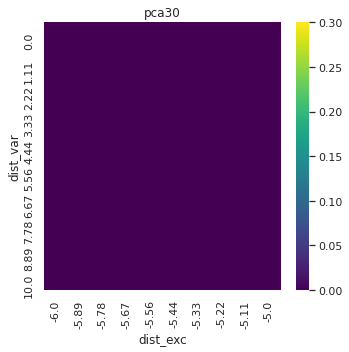

In [5]:
%matplotlib inline
plot_labels = list(prior_dict.keys())
param_labels = list(prior_dict.keys())
all_bounds = [param_dict['bounds'] for param_dict in prior_dict.values()]

for input_type, posterior_dict in posterior_state_dicts.items():
    if input_type in ['psd_peak']:
        continue
    print(input_type)

    x_val = np.load(f'{data_path}/validation_sims/x_{input_type}_validation.npy')
    x_val = x_val[:,0,:]

    theta_val = np.load(f'{data_path}/validation_sims/theta_{input_type}_validation.npy')

    dist_list = list()
    for cond_idx in range(theta_cond.shape[0]):
        start_idx, stop_idx = cond_idx*10, (cond_idx+1)*10
        dist = np.sqrt(np.mean(np.square(x_val[start_idx:stop_idx,:] - np.tile(x_cond[0,:], 10).reshape(10,-1))))
        dist_list.append(dist)
    dist_array = np.array(dist_list)

    plt.figure(figsize=(5,5))
    xticks = np.round(np.linspace(all_bounds[3][0], all_bounds[3][1], 10), decimals=2)
    yticks = np.round(np.linspace(all_bounds[0][0], all_bounds[0][1], 10), decimals=2)
    sns.heatmap(dist_array.reshape(10,10,10,10)[:,5,5,:], vmin=0, vmax=0.3,
                xticklabels=xticks, yticklabels=yticks, cmap='viridis')
    plt.title(input_type)
    plt.xlabel(param_labels[2])
    plt.ylabel(param_labels[0])
    plt.tight_layout()


[1.000000e-10 8.888889e-01 1.000000e-10 1.000000e+00]
[ 68.59899902  44.         -20.89942741  75.        ]


ValueError: x and y can be no greater than 2-D, but have shapes (501,) and (501, 3, 10)

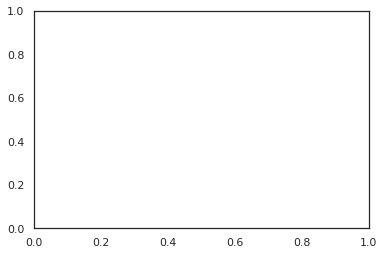

In [14]:
cidx = 809
input_type = 'peak'
print(theta_cond[cidx,:])
print(load_info[input_type]['x_cond'][cidx,:])
x_val = np.load(f'{data_path}/validation_sims/x_{input_type}_validation.npy')
_ = plt.plot(x_val[cidx*10:(cidx+1)*10,:].T, color='k', alpha=0.5)
_ = plt.plot(x_cond[cidx,:], color='r', linewidth=4)

array([1.0000000e-10, 7.7777779e-01, 1.1111111e-01], dtype=float32)